# Verbs

In this notebook we will show what kind of action each action block (i.e. each *verb*) performs. Remember from the [Intro notebook](intro.ipynb) that result instructions are formulated by combining basic building blocks into processing chains. These processing chains start with a reference (e.g. to a semantic concepts) which during query processing is internally evaluated into a *data cube*. For a description of those, see the [References notebook](references.ipynb). Actions are distinct, well-defined data cube operations that can then be applied to these data cubes. Since they are all labelled with an action word that describes their task, we also call them *verbs*.

This notebook will show how these verbs are internally called and executed by the query processor. Although this internal handling is not something you need to deal with as an end-user, understanding it should give you a clearer idea of what each verb exactly does, and also provide a way to test the verbs outside the query processing workflow. At all examples, we will also show the code you would use at the query recipe construction phase to obtain the same result.

## Content

- [Verbs for single data cubes](#Verbs-for-single-data-cubes)
    - [Evaluate](#Evaluate)
    - [Extract](#Extract)
    - [Filter](#Filter)
        - [filter_time](#The-filter_time-and-filter_space-verbs)
        - [filter_space](#The-filter_time-and-filter_space-verbs)
    - [Reduce](#Reduce)
    - [Groupby](#Groupby)
        - [groupby_time](#The-groupby_time-and-groupby_space-verbs)
        - [groupby_space](#The-groupby_time-and-groupby_space-verbs)
    - [Label](#Label)
- [Verbs for data cube collections](#Verbs-for-data-cube-collections)
    - [Concatenate](#Concatenate)
    - [Compose](#Compose)
    - [Merge](#Merge)
    - [Evaluating single cube verbs on collections](#Evaluating-single-cube-verbs-on-collections)

## Prepare

Import the semantique package:

In [1]:
import semantique as sq
from semantique.processor.utils import create_extent_cube

Import other packages we will use in this notebook:

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import json

Now we get some example data to work with. We will ask the ontology to translate some concept references into boolean data cubes, and also ask our demo factbase to retrieve some information layers directly. We will use a very coarse spatial resolution such that we can easily see all values in the data cubes and how they get wrangled by the verbs. For the same reason, we will also round floating point values to one digit.

In [3]:
# Initialize the ontology.
with open("files/ontology.json", "r") as file:
    ontology = sq.ontology.Semantique(json.load(file))

# Initialize the factbase.
with open("files/factbase.json", "r") as file:
    factbase = sq.factbase.GeotiffArchive(json.load(file), src = "files/resources.zip")

# Create a spatio-temporal extent cube.
space = sq.SpatialExtent(gpd.read_file("files/footprint.geojson"))
time = sq.TemporalExtent("2019-01-01", "2020-12-31")
extent = create_extent_cube(space, time, spatial_resolution = [-1800, 1800], crs = 3035, tz = "UTC")

In [4]:
# Translate some semantic concept definitions.
water = ontology.translate("entity", "water", factbase = factbase, extent = extent)
vegetation = ontology.translate("entity", "vegetation", factbase = factbase, extent = extent)
snow = ontology.translate("entity", "snow", factbase = factbase, extent = extent)

In [5]:
concepts = xr.concat([water, vegetation, snow], "concept").rename("concepts")
concepts.coords["concept"] = ["water", "vegetation", "snow"]

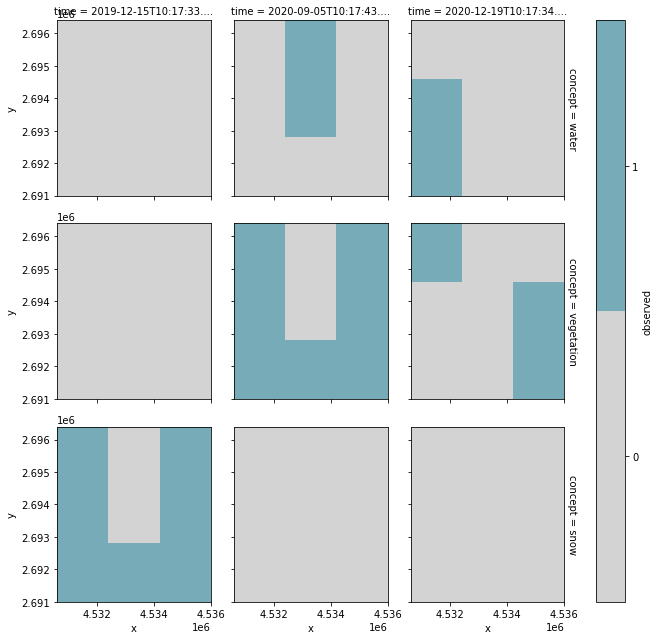

In [6]:
values = [0, 1]
levels = [x - 0.5 for x in values + [max(values) + 1]]
colors = ["#d3d3d3", "#77abb7"]
legend = {"ticks": values, "label": "observed"}
concepts.unstack().plot(col = "time", row = "concept", levels = levels, colors = colors, cbar_kwargs = legend)

In [7]:
# Retrieve the greenness resource.
greenness = factbase.retrieve("appearance", "greenness", extent = extent).round(1)

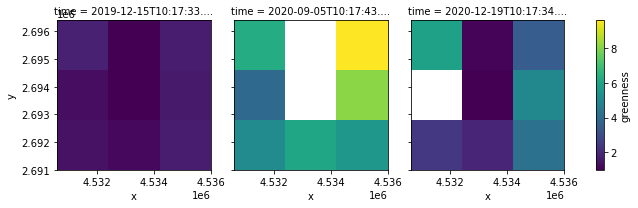

In [8]:
greenness.unstack().plot(col = "time")

In [9]:
# Retrieve the brightness resource.
brightness = factbase.retrieve("appearance", "brightness", extent = extent).round(1)

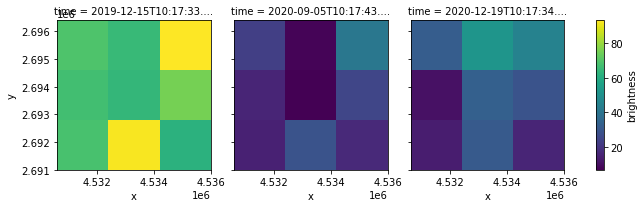

In [10]:
brightness.unstack().plot(col = "time")

## Verbs for single data cubes

`semantique` uses [DataArray](http://xarray.pydata.org/en/stable/user-guide/data-structures.html#dataarray) objects from the `xarray` package to represent data cubes. It extends this class by adding a semantique-specific accessor named `sq`. All the verbs that are meant to be applied on single data cubes are implemented as methods of this accessor. In practice, that means that you can call these verbs in the following form: 

```python
xarray_object.sq.verb()
```

Using accessors instead of the common class inheritance is recommended by the developers of `xarray`. Read more about it [here](http://xarray.pydata.org/en/stable/internals/extending-xarray.html). The internal application of verbs is only shown to examplify their functionalities. Whenever you construct a query recipe, you do **not** call the verbs in this way. At that stage, "data cubes" are simple textual references that do not contain any data just yet, and you simply formulate a processing chain as follows:

```python
reference.verb()
```

The currently implemented verbs are:

- [Evaluate](#Evaluate): Evaluates an expression for each pixel in a data cube.
- [Extract](#Extract): Extracts dimension coordinates of a specified dimension in a data cube.
- [Filter](#Filter): Filters values from a data cube.
- [Reduce](#Reduce): Reduces sets of values along a specified dimension to one and subsequently removes that dimension.
- [Groupby](#Groupby): Groups a data cube into a collection of multiple subsets.
- [Label](#Label): Assigns a label to a data cube.

### Evaluate

The evaluate verb evaluates an expression for each pixel in the input data cube. These expressions can take many different forms, but each of them accepts a pixel value of the input cube as input, and applies some operator to it. The result of that operation is the new value of that particular pixel in the output cube. That is, the output cube always has the *same shape* as the input cube.

Several common operators are built in to `semantique`. When you construct a semantic query recipe, you can simply call them by their name, e.g.:

```python
reference.evaluate("invert")
```

However, since we are now calling the verbs directly as methods of `xarray.DataArray` object, we need to provide the operator *functions* themselves. For that, we load the operators module of `semantique`. This module contains all the built-in operators of the package. Note that the names of these functions always end with an underscore. This is simply to prevent collision with [reserved keywords](https://realpython.com/lessons/reserved-keywords/) in Python.

It is also possible to use custom operators that you define for yourself, but we will not handle that here. See the [Advanced usage notebook](https://zgis.github.io/semantique/_notebooks/advanced.html#Adding-custom-operators) instead.

In [11]:
from semantique.processor import operators

#### Simple univariate expressions

The simplest form of expressions are the univariate expressions without any additional constants or parameters. For each pixel value $x_{i}$ in input cube $X$, these expressions *only* consider $x_{i}$, and apply an operator to it. That is, the expression is of the following form.

$$
expression = operator(x_{i})
$$

This means that the output cube has the same shape as the input cube, and that each pixel value in the output cube is the result of the univariate expression evaluated on the value of the corresponding pixel in the input cube.

![evaluate_univariate](figures/evaluate_uni.png)

The built-in operators for this purpose include the **numerical univariate operators**, which are intended for usage on numerical data cubes:

- `absolute`: Computes the absolute value of $x_{i}$.
- `exponential`: Computes the exponential value of $x_{i}$, i.e. $e^{x_{i}}$.
- `natural_logarithm`: Computes the natural logarithm of $x_{i}$.
- `square_root`: Computes the square root of $x_{i}$.
- `cube_root`: Computes the cube root of $x_{i}$.

Next to those there are the **boolean univariate operators**, which are intended for usage on binary data cubes:

- `invert`: Returns $1$ if $x_{i} = 0$, and $0$ if $x_{i} \neq 0$.

For example, applying the `invert` operator to the water cube marks all non-water pixels as 1 and all water pixels as 0.

In [12]:
water

<xarray.DataArray 'water' (time: 3, space: 9)>
array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0.]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:  binary

In [13]:
water.sq.evaluate(operators.invert_)

<xarray.DataArray 'water' (time: 3, space: 9)>
array([[1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1., 0., 1., 1.]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:    binary
    value_labels:  None

When constructing a query recipe, we would formulate the above example as:

```python
sq.entity("water").evaluate("invert")
```

#### Univariate expressions involving constants

Other expressions involve a constant value in addition to the pixel values from the input cube. Such expressions consist of a right-hand side value, a left-hand side value and an operator that in some way combines these values. For each pixel value $x_{i}$ in input cube $X$, the right-hand side value of the expression is $x_{i}$, and the left-hand side value of the expression is a constant value $y$. Hence, $y$ remains the same no matter for which pixel in $X$ the expression is evaluated. For example, we could add `1` to each pixel value, or multiply each pixel value by `2`. 

$$
expression = x_{i} \; operator \; y
$$

This means that the output cube has the same shape as the input cube, and that each pixel value in the output cube is the result of the expression evaluated on the value of the corresponding pixel in the input cube, with each expression containing some constant value $y$ which is the same for each pixel.

![evaluate_constant](figures/evaluate_const.png)

The built-in operators for this purpose can be subdivided into different categories. The **algebraic operators** are intended for usage on numerical data cubes and perform an operation of arithmetic:

- `add`: Adds some constant $y$ to each pixel value $x_{i}$, e.g. $x_{i} + 2$ when $y = 2$.
- `subtract`: Subtracts some constant $y$ from each pixel value $x_{i}$, e.g. $x_{i} - 2$ when $y = 2$.
- `multiply`: Multiplies each pixel value $x_{i}$ by some constant $y$, e.g. $x_{i} \times 2$ when $y = 2$.
- `divide`: Divides each pixel value $x_{i}$ by some constant $y$, e.g. $\frac{x_{i}}{2}$ when $y = 2$.
- `power`: Raises each pixel value $x_{i}$ to the *y*th power for some constant $y$, e.g. $x_{i} ^ 2$ when $y = 2$.

The **relational operators** evaluate a condition involving two values. The result is always a boolean value, i.e. true (1) when the condition holds and false (2) when it doesn't. Some of the conditions test for equality, and hence can be used on any data cube as long as the constant $y$ matches the value type of the data cube:

- `equal`: Returns $1$ if $x_{i} = y$, and $0$ otherwise.
- `not_equal`: Returns $1$ if $x_{i} \neq y$, and $0$ otherwise.
- `in`: Returns $1$ if $x_{i} \in Y$, and $0$ otherwise. Here, $Y$ is a finite set of values that remains constant for each $x_{i}$.
- `not_in`: Returns $1$ if $x_{i} \notin Y$, and $0$ otherwise. Here, $Y$ is a finite set of values that remains constant for each $x_{i}$.

The other conditions imply a fixed order among the values, and hence should not be used on nominal data cubes:

- `greater`: Returns $1$ if $x_{i} > y$, and $0$ otherwise.
- `less`: Returns $1$ if $x_{i} < y$, and $0$ otherwise.
- `greater_equal`: Returns $1$ if $x_{i} \geq y$, and $0$ otherwise.
- `less_equal`:Returns $1$ if $x_{i} \leq y$, and $0$ otherwise.

In [14]:
greenness

<xarray.DataArray 'greenness' (time: 3, space: 9)>
array([[1.8, 1. , 1.7, 1.3, 1. , 1.6, 1.4, 1.2, 1.7],
       [6.3, nan, 9.6, 3.9, nan, 8.1, 5.1, 6.1, 5.6],
       [5.9, 1.1, 3.5, nan, 1. , 5. , 2.4, 1.9, 4.2]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     greenness
    _FillValue:    1.7976931348623157e+308
    value_type:    numerical

In [15]:
greenness.sq.evaluate(operators.multiply_, 2)

<xarray.DataArray (time: 3, space: 9)>
array([[ 3.6,  2. ,  3.4,  2.6,  2. ,  3.2,  2.8,  2.4,  3.4],
       [12.6,  nan, 19.2,  7.8,  nan, 16.2, 10.2, 12.2, 11.2],
       [11.8,  2.2,  7. ,  nan,  2. , 10. ,  4.8,  3.8,  8.4]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:  numerical

In [16]:
greenness.sq.evaluate(operators.greater_, 2)

<xarray.DataArray (time: 3, space: 9)>
array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., nan,  1.,  1., nan,  1.,  1.,  1.,  1.],
       [ 1.,  0.,  1., nan,  0.,  1.,  1.,  0.,  1.]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:  binary

When constructing a query recipe, we would formulate the above examples as:

```python
sq.appearance("greenness").evaluate("multiply", 2)
sq.appearance("greenness").evaluate("greater", 2)
```

#### Multivariate expressions

In the examples above $y$ remained the same no matter for which pixel in $X$ the expression was evaluated. Instead, $y$ could be a variable as well. That turns the same expressions into *multivariate expressions*. In practice this means that when evaluating the expression for the pixel with value $x_{i} \in X$, we set $y$ to be equal to pixel value $y_{i}$ taken from another data cube $Y$.

$$
expression = x_{i} \; operator \; y_{i}
$$

This means that the output cube has the same shape as the input cube, and that each pixel value in the output cube is the result of the multivariate expression evaluated on the value of the corresponding pixel in the input cube *and* the value of that pixel with the same coordinates in another data cube $Y$. Note that this does require that $Y$ has the *same shape* as $X$ (or at least can be aligned to that shape, which we will explain in the next sub-section). Only then, each pixel in $X$ has a *matching* pixel in $Y$.

![evaluate_multivariate](figures/evaluate_multi.png)

We can use the same algebraic expressions in these cases. These are meant to be used in expression in which both sides are numerical data cubes:

- `add`: Adds pixel value $y_{i} \in Y$ to each pixel value $x_{i} \in X$..
- `subtract`: Subtracts pixel value $y_{i} \in Y$ from each pixel value $x_{i} \in X$.
- `multiply`: Multiplies each pixel value $x_{i} \in X$ by pixel value $y_{i} \in Y$.
- `divide`: Divides each pixel value $x_{i} \in X$ by pixel value $y_{i} \in Y$.
- `power`: Raises each pixel value $x_{i} \in X$ to the *y*th power, where $y = y_{i} \in Y$.

We can also use the relational operators that test for equality, except the `in` and `not_in` operators, since they expect a set of values as the right-hand side of the expression. The equality operators can be used on any data cube as long as the value type of the second data cube is the same as the value type of the first data cube:

- `equal`: Returns $1$ if $x_{i} = y_{i}$, and $0$ otherwise.
- `not_equal`: Returns $1$ if $x_{i} \neq y_{i}$, and $0$ otherwise.

The same yields for the relational operators that imply a fixed order in the values of the cube: these can be used on any non-nominal data cube as long as the value type of the second data cube is the same as the value type of the first data cube:

- `greater`: Returns $1$ if $x_{i} > y_{i}$, and $0$ otherwise.
- `less`: Returns $1$ if $x_{i} < y_{i}$, and $0$ otherwise.
- `greater_equal`: Returns $1$ if $x_{i} \geq y_{i}$, and $0$ otherwise.
- `less_equal`:Returns $1$ if $x_{i} \leq y_{i}$, and $0$ otherwise.

The simplest (but pretty useless) example is to compare the water cube to itself. As expected, this returns an array with solely "true" values.

In [17]:
water.sq.evaluate(operators.equal_, water)

<xarray.DataArray 'water' (time: 3, space: 9)>
array([[1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:  binary

When constructing a query recipe, we would formulate the above example as:

```python
sq.entity("water").evaluate("equal", sq.self())
```

Of course we are not bound to use the same cube as $X$ and $Y$. We just need to make sure both cubes have the same shape.

In [18]:
greenness.shape

(3, 9)

In [19]:
brightness.shape

(3, 9)

In [20]:
greenness.sq.evaluate(operators.add_, brightness)

<xarray.DataArray (time: 3, space: 9)>
array([[70.8, 66. , 94.7, 68.3, 65. , 76.6, 69.4, 93.2, 63.7],
       [29.3,  nan, 50.6, 19.9,  nan, 33.1, 20.1, 35.1, 22.6],
       [37.9, 53.1, 48.5,  nan, 34. , 34. , 16.4, 32.9, 20.2]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:  numerical

When constructing a query recipe, we would formulate the above example as:

```python
sq.appearance("greenness").evaluate("add", sq.appearance("brightness"))
```

There is an additional set of operators we can use for multivariate expressions. These are the **boolean multivariate operators**. The are intended to be used in expressions involving two binary data cubes.

- `and`: Returns $1$ when both $x_{i} \neq 0$ *and* $y_{i} \neq 0$, and $0$ otherwise.
- `or`: Returns $1$ when $x_{i} \neq 0$, $y_{i} \neq 0$, or both, and $0$ otherwise.
- `exclusive_or`: Returns $1$ when either $x_{i} \neq 0$ *or*  $y_{i} \neq 0$, but *not* both, and $0$ otherwise.

In [21]:
water.sq.evaluate(operators.and_, snow)

<xarray.DataArray (time: 3, space: 9)>
array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:    binary
    value_labels:  None

In [22]:
water.sq.evaluate(operators.or_, snow)

<xarray.DataArray (time: 3, space: 9)>
array([[1., 0., 1., 1., 0., 1., 1., 1., 1.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0.]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:    binary
    value_labels:  None

When constructing a query recipe, we would formulate the above examples as:

```python
sq.entity("water").evaluate("and", sq.entity("snow"))
sq.entity("water").evaluate("or", sq.entity("snow"))
```

#### Aligning data cubes to the same shape

As mentioned above, cube $Y$ does not necessarily have to be of the same shape as input cube $X$, but it should at least be possible to *align* it to that shape. This can be done in two ways.

First consider the case where $Y$ has the same dimensions as $X$, but not all coordinate values of $X$ are present in $Y$. In that case, we can align $Y$ with $X$ such that pixel values at position $i$ in both cubes, i.e. $x_{i}$ and $y_{i}$ respectively, belong to pixels with the *same coordinates*. If $y_{i}$ was not originally part of $Y$, we assign it a nodata value. In that way, we can at least correctly evaluate the expression for those pixels in $X$ that do have a matching pixel with a value in $Y$.

![evaluate_align_same_dims](figures/evaluate_align1.png)

Below we show an example. Since `align_with` is a method that operates on `xarray.DataArray` object but is added by `semantique`, we can also call it through the `sq` accessor, just as the verbs. Note that we just show the alignment process for the sake of demonstration. Whenever you call the `evaluate` verb with a cube as y-value, the alignment is taken care of internally.

In [23]:
# Recall the shape of our water cube.
water

<xarray.DataArray 'water' (time: 3, space: 9)>
array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0.]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:  binary

In [24]:
# Now create a snow cube that has only a subset of the coordinates of the water cube.
snow_subset = snow.isel(space = range(3, 6))
snow_subset

<xarray.DataArray 'snow' (time: 3, space: 3)>
array([[1., 0., 1.],
       [0., 0., 0.],
       [0., 0., 0.]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.694e+06 2.694e+06 2.694e+06
  - x             (space) float64 4.532e+06 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0
Attributes:
    value_type:  binary

In [25]:
# Aligning it makes sure that pixels with equal coordinates in the snow and water cubes are at the same position.
snow_subset.sq.align_with(water)

<xarray.DataArray 'snow' (time: 3, space: 9)>
array([[nan, nan, nan,  1.,  0.,  1., nan, nan, nan],
       [nan, nan, nan,  0.,  0.,  0., nan, nan, nan],
       [nan, nan, nan,  0.,  0.,  0., nan, nan, nan]])
Coordinates:
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
    feature       (space) float64 nan nan nan 1.0 1.0 1.0 nan nan nan
Attributes:
    value_type:  binary

In [26]:
# The reverse is also true:
# When the input cube X has only a subset of the coordinates of the Y cube, we can align Y to X.
snow.sq.align_with(water.isel(space = range(3, 6)))

<xarray.DataArray 'snow' (time: 3, space: 3)>
array([[1., 0., 1.],
       [0., 0., 0.],
       [0., 0., 0.]])
Coordinates:
  * space         (space) MultiIndex
  - y             (space) float64 2.694e+06 2.694e+06 2.694e+06
  - x             (space) float64 4.532e+06 4.533e+06 4.535e+06
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
    feature       (space) float64 1.0 1.0 1.0
Attributes:
    value_type:  binary

Now consider a case where $Y$ has one or more dimensions with exactly the same coordinate values as $X$, but does not have *all* the dimensions that $X$ has. In that case, we can align $Y$ with $X$ by duplicating its values along those dimensions that are missing.

![evaluate_align_missing_dims](figures/evaluate_align2.png)

For example, when $X$ has a time and a space dimension, but $Y$ only the time dimension, we can align $Y$ to $X$ as follows:

In [27]:
# Recall the shape of our water cube.
water

<xarray.DataArray 'water' (time: 3, space: 9)>
array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0.]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:  binary

In [28]:
# Now create a snow cube that has only a time dimension.
snow_temporal = snow.isel(space = 8, drop = True)
snow_temporal

<xarray.DataArray 'snow' (time: 3)>
array([1., 0., 0.])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
Attributes:
    value_type:  binary

In [29]:
# Aligning it duplicates for each timestamp the values of Y along all spatial locations in X.
snow_temporal.sq.align_with(water)

<xarray.DataArray 'snow' (time: 3, space: 9)>
array([[1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
Attributes:
    value_type:  binary

The latter behaviour is *not* symmetric. When cube $Y$ has more dimensions that cube $X$, there is no clear way to define how to subset the values in $Y$ to match the shape of $X$. In that case, the alignment will raise an error.

#### The assignment operator

A special operator is the `assign` operator. This operator assigns each pixel $x_{i}$ of data cube $X$ a new value that has nothing to do with the original value. The new value can either some constant $y$, or the corresponding pixel value $y_{i}$ in another data cube $Y$.

This operator becomes useful for example when you first filter your values based on some condition (using the [filter verb](#Filter)), and then want to replace the remaining values with a pre-defined constant (i.e. using that value as some sort of label for those pixels that passed the condition).

In [30]:
brightness.sq.filter(vegetation).sq.evaluate(operators.assign_, 999)

<xarray.DataArray (time: 3, space: 9)>
array([[ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [999.,  nan, 999., 999.,  nan, 999., 999., 999., 999.],
       [999.,  nan,  nan,  nan,  nan, 999.,  nan,  nan, 999.]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:  numerical

When constructing a query recipe, we would formulate the above example as:

```python
sq.appearance("brightness").filter(sq.entity("vegetation")).evaluate("assign", 999)
```

Another useful example follows from alignment behaviour as explained in the previous section. This allows you to for example to replace all pixel values in a data cube by the timestamp (or a component of the timestamp, e.g. the year) at which they were observed.

In [31]:
years = water.time.dt.year
water.sq.evaluate(operators.assign_, years)

<xarray.DataArray (time: 3, space: 9)>
array([[2019., 2019., 2019., 2019., 2019., 2019., 2019., 2019., 2019.],
       [2020., 2020., 2020., 2020., 2020., 2020., 2020., 2020., 2020.],
       [2020., 2020., 2020., 2020., 2020., 2020., 2020., 2020., 2020.]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:  numerical

When constructing a query recipe, we would formulate the above example as:

```python
sq.entity("water").evaluate("assign", sq.self().extract("time", "year"))
```

#### Temporal relational operators

There is a special set of relational operators we did not touch upon yet: the **temporal relational operators**. These are comparison operators specifically designed to deal with *time instants* and *time intervals* as operand values. Hence, it requires each pixel value $x_{i}$ in input cube $X$ to be a time instant. The right-hand side of the expression can either be a single time instant, a time interval (i.e. a list of two time instant representing the start and end of the interval) or another data cube $Y$ in which each pixel value $y_{i}$ is a time instant. The latter will in practice be evaluated as being a time interval with the earliest time instant being the start of the interval, and the latest time instant the end of the interval.

The currently implemented temporal relational operators are:

- `after`: When $y$ is a time instant: returns $1$ if $x_{i} > y$, and $0$ otherwise. When $y$ is a time interval: returns $1$ if $x_{i} > max(y)$, and $0$ otherwise.
- `before`: When $y$ is a time instant: returns $1$ if $x_{i} < y$, and $0$ otherwise. When $y$ is a time interval: returns $1$ if $x_{i} < min(y)$, and $0$ otherwise.
- `during`: Returns $1$ if $min(y) \leq x_{i} \leq max(y)$, and $0$ otherwise. Only intended for time intervals as $y$.

In [32]:
times = water.time
times.sq.evaluate(operators.after_, np.datetime64("2019-12-31"))

<xarray.DataArray 'time' (time: 3)>
array([0., 1., 1.])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
Attributes:
    value_type:  binary

In [33]:
times.sq.evaluate(operators.during_, [np.datetime64("2019-12-01"), np.datetime64("2020-12-01")])

<xarray.DataArray 'time' (time: 3)>
array([1., 1., 0.])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
Attributes:
    value_type:  binary

When constructing a query recipe, you can use the `sq.time_instant` and `sq.time_interval` functions to create time instants and time intervals. The first expects a single time value, the second expects two time values (i.e. start and end). Just as with initializing temporal extents, the provided time values can be in any format that the [Timestamp](https://pandas.pydata.org/docs/reference/api/pandas.Timestamp.html) initializer of the `pandas` package can understands. This includes formats like `"2020-12-31"` or `"2020/12/31"`, but also complete ISO8601 timestamps. Any additional keyword arguments will be forwarded to pandas initializer. Internally the query processor will convert them to `numpy.datetime64` objects.

That is, we would formulate the above examples as:

```python
sq.entity("water").extract("time").evaluate("after", sq.time_instant("2019-12-31"))
sq.entity("water").extract("time").evaluate("during", sq.time_interval("2019-12-30", "2020-12-30"))
```

#### Spatial relational operators

Similar to the temporal relational operators, there is also a set of **spatial relational operators**. These are comparison operators specifically designed to deal with *geometries* as operand values. It requires each pixel value $x_{i}$ in input cube $X$ to be a tuple of spatial (x,y) coordinates. The right-hand side of the expression can either be a geometry object or another data cube $Y$ in which each pixel value $y_{i}$ is a coordinate tuple. The latter will in practice be evaluated as being a geometry covering the spatial bounding box of the cube.

The currently implemented spatial relational operators are:

- `intersects`: Returns $1$ if the spatial point with the coordinates of $x_{i}$ spatially intersects with geometry $y$, and $0$ otherwise.

In [34]:
coords = water.space
geoms = gpd.read_file("files/parcels.geojson").to_crs(3035)
coords.sq.evaluate(operators.intersects_, geoms)

<xarray.DataArray (space: 9)>
array([0, 1, 0, 0, 0, 0, 0, 0, 0])
Coordinates:
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:  binary

When constructing a query recipe, you can use the `sq.geometries` function to create a geometry object. Just as with initializing spatial extents, the provided value can be any object that can be read by the [GeoDataFrame](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.html) initializer of the `geopandas` package. Any additional keyword arguments will be forwarded to this initializer. In practice, this means you can read any GDAL-supported file format with `geopandas.read_file`, and then forward the resulting `GeoDataFrame` directly to the `sq.geometries` function.

That is, we would formulate the above example as:

```python
geoms = gpd.read_file("files/parcels.geojson")
sq.entity("water").extract("space").evaluate("intersects", sq.geometries(geoms))
```

### Extract

The extract verbs extracts the coordinates of a specified dimension from a data cube.

![extract](figures/extract.png)

In [35]:
water.sq.extract("time")

<xarray.DataArray 'time' (time: 3)>
array(['2019-12-15T10:17:33.408715000', '2020-09-05T10:17:43.167942000',
       '2020-12-19T10:17:34.610661000'], dtype='datetime64[ns]')
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
Attributes:
    value_type:  time

When constructing a query recipe, we would formulate the above example as:

```python
sq.entity("water").extract("time")
```

Coordinate values of some dimensions may consist of multiple components. For example, the spatial dimension contains coordinate tuples that consist of x and y coordinates, and the time dimension contains timestamps that consist of a year, a month, a day, an hour, etc. If you are only interested in a single component of a dimension, you can specify that through the `component` argument of the extract verb:

In [36]:
water.sq.extract("time", "year")

<xarray.DataArray 'year' (time: 3)>
array([2019, 2020, 2020])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
Attributes:
    value_type:  numerical

When constructing a query recipe, we would formulate the above example as:

```python
sq.entity("water").extract("time", "month")
```

Extracting coordinates of a (component of a) dimension is useful for example when you want to filter a data cube based on its dimension coordinates rather than based on its values (e.g. [temporal filtering](#Aligning-the-filterer)), when you want to [replace](#Replace) pixel values by their time of observation, or when you want to split a data cube into multiple groups along a dimension (e.g. [grouping by year](#Groupby)).

### Filter

The filter verb filters values from a data cube. That is, the output cube is a *subset* of the input cube. Which values in the input cube are kept, and which are removed, is defined by a second, boolean data cube which we call the *filterer*. The filterer should have the same shape as the input cube, such that each pixel value $x_{i}$ in input cube $X$ has a *matching* pixel value $y_{i}$ in filterer $Y$. Then:

- $x_{i}$ is kept if $y_{i} \neq 0$.
- $x_{i}$ is removed if $y_{i} = 0$.

![filter](figures/filter.png)

For example, we may filter only those greenness values of pixels where water or snow was observed.

In [37]:
# Recall the values of the brightness cube.
brightness

<xarray.DataArray 'brightness' (time: 3, space: 9)>
array([[69., 65., 93., 67., 64., 75., 68., 92., 62.],
       [23.,  8., 41., 16.,  7., 25., 15., 29., 17.],
       [32., 52., 45., 11., 33., 29., 14., 31., 16.]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     brightness
    _FillValue:    1.7976931348623157e+308
    value_type:    numerical

In [38]:
# Create the filterer by marking the pixels where water or snow was observed as "true".
filterer = water.sq.evaluate(operators.or_, snow)
filterer

<xarray.DataArray (time: 3, space: 9)>
array([[1., 0., 1., 1., 0., 1., 1., 1., 1.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0.]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:    binary
    value_labels:  None

In [39]:
# Filter the values of the brightness cube using the filterer.
brightness.sq.filter(filterer)

<xarray.DataArray 'brightness' (time: 3, space: 9)>
array([[69., nan, 93., 67., nan, 75., 68., 92., 62.],
       [nan,  8., nan, nan,  7., nan, nan, nan, nan],
       [nan, nan, nan, 11., nan, nan, 14., nan, nan]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     brightness
    _FillValue:    1.7976931348623157e+308
    value_type:    numerical

When constructing a query recipe, we would formulate the above example as:

```python
sq.appearance("brightness").filter(sq.entity("water").evaluate("or", sq.entity("snow")))
```

#### Aligning the filterer

Just as with the $Y$ and $X$ cubes in multivariate expressions in the `evaluate` verb, the filterer does not have to be of the same shape as the input cube, as long as we can align it to that shape. That means that we can also filter the input cube by the coordinates of one of its dimensions. All we have to do is to construct a filterer for that dimension. Hence, a boolean, one-dimensional data cube that specifies for each of the coordinate values of that dimension if it should be kept (i.e. 1) or removed (i.e. 0).

![filter_align](figures/filter_align.png)

For example, when we only want to keep pixel values observed in 2019:

In [40]:
# Extract the years from the time dimension.
years = water.sq.extract("time", "year")
years

<xarray.DataArray 'year' (time: 3)>
array([2019, 2020, 2020])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
Attributes:
    value_type:  numerical

In [41]:
# Create a filterer for the time dimension.
filterer = years.sq.evaluate(operators.equal_, 2020)
filterer

<xarray.DataArray (time: 3)>
array([0., 1., 1.])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
Attributes:
    value_type:  binary

In [42]:
# Filter the values of the water cube using the dimension filterer.
water.sq.filter(filterer)

<xarray.DataArray 'water' (time: 3, space: 9)>
array([[nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [ 0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:  binary

When constructing a query recipe, we would formulate the above example as:

```python
sq.entity("water").filter(sq.self().extract("time", "year").evaluate("equal", 2020))
```

#### The filter_time and filter_space verbs
You can also use a handy shortcut for the above formulation: the `filter_time` verb. This allows you to apply a temporal filter *without* having to explicitly extract the time coordinates from the active evaluation object and evaluating a comparison expression on them. Hence, you could formulate exactly the same example as:

```python
sq.entity("water").filter_time("year", "equal", 2020)
```

Note that this is only a "shortcut" verb, not an independent verb on its own. Hence, calling `filter_time` will result in a textual recipe that contains the self reference and the extract and evaluate verbs, i.e. that is exactly equal to the textual recipe of the first formulation. In the same way, you can also use `filter_space` for spatial filters.

#### Self-filtering

A special type of a filtering operation is self-filtering, i.e. filtering a data cube by itself. In this case, the input cube should be boolean. In the output, the "true" values will be preserved, while the "false" values are removed.

![filter_self](figures/filter_self.png)

In [43]:
water

<xarray.DataArray 'water' (time: 3, space: 9)>
array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0.]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:  binary

In [44]:
water.sq.filter(water).sq.trim(force_regular = False)

<xarray.DataArray 'water' (time: 2, space: 4)>
array([[ 1., nan,  1., nan],
       [nan,  1., nan,  1.]])
Coordinates:
  * time          (time) datetime64[ns] 2020-09-05T10:17:43.167942 2020-12-19...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.694e+06 2.694e+06 2.692e+06
  - x             (space) float64 4.533e+06 4.532e+06 4.533e+06 4.532e+06
    feature       (space) float64 1.0 1.0 1.0 1.0
Attributes:
    value_type:  binary

When constructing a query recipe, we would formulate the above example as:

```python
sq.entity("water").filter(sq.self())
```

### Reduce

The reduce verb applies a reducer function along a dimension and subsequently drops the reduced dimension. That is, the output cube always has one dimension less than the input cube.

To reduce a dimension, the reducer function operates on each slice of values along the axis of the dimension. Such a *slice* contains one value for each coordinate label of the dimension to reduce over, while the coordinate labels of all other dimensions are *constant* within each slice. The reducer function always returns a single value, such that each slice gets reduced from $n$ values to one value.

For example: a data cube with a spatial and a temporal dimension contains for each location in space $n$ values, where $n$ is the number of timestamps in the temporal dimension. When we reduce the temporal dimension of this cube, the reducer function reduces these $n$ values for each location in space to one value. The resulting cube has a single value per location in space, and no temporal dimension anymore.

![reduce](figures/reduce.png)

Several common reducers are built in to `semantique`. When you construct a semantic query recipe, you can simply call them by their name, e.g.:

```python
reduce("time", "mean")
```

However, since we are now calling the verbs directly as methods of `xarray.DataArray` object, we need to provide the reducer *functions* themselves. For that, we load the reducers module of `semantique`. This module contains all the built-in reducers of the package. Note that the names of these functions always end with an underscore. This is simply to prevent collision with reserved [keywords](https://realpython.com/lessons/reserved-keywords/) in Python.

It is also possible to use custom reducers that you define for yourself, but we will not handle that here. See the [Advanced usage notebook](https://zgis.github.io/semantique/_notebooks/advanced.html#Adding-custom-reducers) instead.

In [45]:
import geopandas as gpd

In [46]:
space.features.to_crs(3035).geometry

0    POLYGON ((4530114.000 2690997.000, 4530114.000...
Name: geometry, dtype: geometry

In [47]:
space.features.to_crs(3035).geometry.bounds

,minx,miny,maxx,maxy
0,4.530114e+06,2.690997e+06,4.535867e+06,2.696634e+06


In [48]:
4531114, 2690997, 4535867, 2695634

(4531114, 2690997, 4535867, 2695634)

In [49]:
from semantique.processor import reducers

The are many different types of reducers available. The **numerical reducers** should be used only on numerical data cubes. The reduced cube will be numerical as well.

- `mean`: Returns the average value of each slice $S$.
- `product`: Returns the product of the values in each slice $S$.
- `sum`: Returns the sum of the values in each slice $S$.
- `standard_deviation`: Returns the standard deviation of the values in each slice $S$.
- `variance`: Returns the variance of the values in each slice $S$.

In the same way, the **boolean reducers** should be used only on boolean data cubes, and the reduced cube will be boolean as well.

- `all`: For each slice $S$, returns $1$ if all $x_{i} \in S \neq 0$, and $0$ otherwise.
- `any`: For each slice $S$, returns $1$ if any $x_{i} \in S \neq 0$, and $0$ otherwise.

Also the **count reducers** should only be used on boolean data cubes. However, the resulting data cubes will be numerical. The count reducers count the number of "true" observations. Where `count` is an absolute count, `percentage` makes it relative by calculating the percentage of "true" observations among all observations. Usually the latter is prefered, since the total amount of observations can differ among e.g. different moments in time and/or different spatial locations.

- `count`: Counts the number of non-zero values in each slice $S$.
- `percentage`: Calculates the percentage of non-zero values in each slice $S$.

The **universal reducers** can be applied to a data cube of any value type. They just return one of the existing values for each slice. Hence, the reduced cube will have the same value type as the input cube.

- `mode`: Returns the most occuring value in each slice $S$.
- `first`: Returns the first value of each slice $S$.
- `last`: Returns the last value of each slice $S$.

The **ordered reducers** also return one of the existing values for each slice. However, they imply a fixed order of the values. Therefore, these reducers should not be applied to nominal data cubes.

- `max`: Returns the largest value in each slice $S$.
- `min`: Returns the smallest value in each slice $S$.
- `median`: Returns the median value of each slice $S$.

It is important to mention that nodata values are **ignored** by the reducer functions! That is, for example, when a slice has the values `[1, 1, nan, 1]` the `all` reducer will return `1` and the `percentage` reducer will return `100`. A reducer will only return a nodata value when *all* values in a slice are nodata values.

Having said that, lets show some examples. The `reduce` verb takes as first argument the name of the dimension to be reduced over, and as second argument the reducer function to be applied.

In [50]:
snow

<xarray.DataArray 'snow' (time: 3, space: 9)>
array([[1., 0., 1., 1., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:  binary

In [51]:
snow.sq.reduce("time", reducers.count_)

<xarray.DataArray 'snow' (space: 9)>
array([1., 0., 1., 1., 0., 1., 1., 1., 1.])
Coordinates:
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:  numerical

In [52]:
snow.sq.reduce("space", reducers.count_)

<xarray.DataArray 'snow' (time: 3)>
array([7., 0., 0.])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
Attributes:
    value_type:  numerical

In [53]:
brightness.sq.reduce("space", reducers.mean_)

<xarray.DataArray 'brightness' (time: 3)>
array([72.77777778, 20.11111111, 29.22222222])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
Attributes:
    value_type:  numerical

When constructing a query recipe, we would formulate the above examples as:

```python
sq.entity("snow").reduce("time", "count")
sq.entity("snow").reduce("space", "count")
sq.appearance("brightness").reduce("space", "mean")
```

### Groupby

The groupby verb splits a data cube into multiple smaller data cubes, called groups. That is, the output cube is a collection of multiple subsets of the input cube. Grouping is always done *along* a dimension. That means that first the coordinate labels of this dimension are divided into distinct groups. Then, the input cube is split such that for each of these groups there is a subset of the input cube containing all pixels that have a coordinate for the given dimension which matches a label in the group. How the coordinate labels are grouped is defined by a second, categorical data cube which we call the *grouper*. The grouper should be a one-dimensional data cube with a dimension that *matches* an existing dimension in the input cube. Then, coordinate labels $\theta_{i}$ and $\theta_{j}$ of grouper $Y$ are in the same group if and only if $y_{i} = y_{j}$.

![groupby_single](figures/groupby_single.png)

For example, we may group the water cube along the time dimension such that pixels observed in different years end up in different subsets. The result of this operation is an object of class `CubeCollection`, which is nothing more than a list of multiple data cubes. These `CubeCollection` object have specific verbs to combine their elements into a single data cube again. For a description of those, see [this section](#Verbs-for-data-cube-collections).

In [54]:
grouper = water.sq.extract("time", "year")
grouper

<xarray.DataArray 'year' (time: 3)>
array([2019, 2020, 2020])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
Attributes:
    value_type:  numerical

In [55]:
groups = water.sq.groupby(grouper)

for group in groups:
    print(group)

<xarray.DataArray 2019 (time: 1, space: 9)>
array([[0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:  binary
<xarray.DataArray 2020 (time: 2, space: 9)>
array([[0., 1., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0.]])
Coordinates:
  * time          (time) datetime64[ns] 2020-09-05T10:17:43.167942 2020-12-19...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    f

When constructing a query recipe, we would formulate the above example as:

```python
sq.entity("water").groupby(sq.self().extract("time", "year"))
```

#### The groupby_time and groupby_space verbs

You can also use a handy shortcut for the above formulation: the `groupby_time` verb. This allows you to group along the temporal dimension *without* having to explicitly extract the time coordinates from the active evaluation object. Hence, you could formulate exactly the same example as:

```python
sq.entity("water").groupby_time("year")
```

Note that this is only a "shortcut" verb, not an independent verb on its own. Hence, calling `groupby_time` will result in a textual recipe that contains the self reference and the extract verb, i.e. that is exactly equal to the textual recipe of the first formulation. In the same way, you can also use `groupby_space` for grouping directly along the spatial dimension.

#### Multiple groupers

It is also possible to provide a list (or `CubeCollection`) of groupers to the `groupby` verb, as long as their dimensions match. In that case, groups of coordinate labels are formed as follows: given grouper $Y$ and grouper $Z$ with matching coordinates, coordinate labels $\theta_{i}$ and $\theta_{j}$ are in the same group if and only if $y_{i} = y_{j}$ *and* $z_{i} = z_{j}$.

![groupby_multi](figures/groupby_multi.png)

That means for example that we can group the input cube along the time dimension in a way that two pixels observed in the same month but a different year end up in a different subset.

In [56]:
# Grouping just by month returns a collection of two cubes: one for september and one for december.
groups = water.sq.groupby(water.sq.extract("time", "month"))

for group in groups:
    print(group)

<xarray.DataArray 9 (time: 1, space: 9)>
array([[0., 1., 0., 0., 1., 0., 0., 0., 0.]])
Coordinates:
  * time          (time) datetime64[ns] 2020-09-05T10:17:43.167942
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:  binary
<xarray.DataArray 12 (time: 2, space: 9)>
array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0.]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 2020-12-19...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    featur

In [57]:
# When we group instead by month *and* year, we get a collection of three cubes.
# Since two of our december timestamps are in different years.
groups = water.sq.groupby([water.sq.extract("time", "year"), water.sq.extract("time", "month")])

for group in groups:
    print(group)

<xarray.DataArray (2019, 12) (space: 9)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0.])
Coordinates:
    time          datetime64[ns] 2019-12-15T10:17:33.408715
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:  binary
<xarray.DataArray (2020, 9) (space: 9)>
array([0., 1., 0., 0., 1., 0., 0., 0., 0.])
Coordinates:
    time          datetime64[ns] 2020-09-05T10:17:43.167942
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    val

When constructing a query recipe, we would formulate the above example as:

```python
grouper = sq.collection(sq.self().extract("time", "year"), sq.self().extract("time", "month"))
sq.entity("water").groupby(grouper)
```

Or equivalently:

```python
sq.entity("water").groupby_time(["year", "month"])
```

Another example, focusing on the spatial dimension, is the following. Recall that our water cube has a space dimension of length 9, i.e. there are 9 pixels in our spatial extent. Each of them has a unique pair of an x and y coordinate. There are  3 distinct x coordinate values, and 3 distinct y coordinate values. That is, when we group our water cube along the space dimension with the groups based on x coordinate values, we end up with 3 subsets. The same yields when we base the groups on y coordinate values. However, when we base the groups on the *combination* of x *and* y coordinate values, we should get 9 subsets. In that case, each pixel forms its own subset, since each pixel has a unique combination of x and y coordinate values.

Lets confirm this:

In [58]:
x_grouper = water.sq.extract("space", "x")
x_grouper

<xarray.DataArray 'x' (space: 9)>
array([4531500., 4533300., 4535100., 4531500., 4533300., 4535100., 4531500.,
       4533300., 4535100.])
Coordinates:
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:  numerical

In [59]:
y_grouper = water.sq.extract("space", "y")
y_grouper

<xarray.DataArray 'y' (space: 9)>
array([2695500., 2695500., 2695500., 2693700., 2693700., 2693700., 2691900.,
       2691900., 2691900.])
Coordinates:
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:  numerical

In [60]:
# Grouping the water cube by x coordinate values gives a collection with four subsets.
len(water.sq.groupby(x_grouper))

3

In [61]:
# Grouping the water cube by y coordinate values gives a collection with four subsets.
len(water.sq.groupby(y_grouper))

3

In [62]:
# Grouping the water cube by x *and* y coordinate values gives a collection with sixteen subsets.
len(water.sq.groupby([x_grouper, y_grouper]))

9

When constructing a query recipe, we would formulate the above example as:

```python
grouper = sq.collection(sq.self().extract("space", "x"), sq.self().extract("space", "y"))
sq.entity("water").groupby(grouper)
```

Or equivalently:

```python
sq.entity("water").groupby_space(["x", "y"])
```

### Label

One additional verb is the label verb. This verb does not perform any analytical task, but simply assigns a label to the input cube. In some cases this can be helpful. For example, when concatenating multiple cubes together along a new dimension (see [here](#Concatenate)), the labels of these cubes will be used as coordinate labels of this new dimension.

In [63]:
water.sq.label("some_other_name")

<xarray.DataArray 'some_other_name' (time: 3, space: 9)>
array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0.]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:  binary

When constructing a query recipe, we would formulate the above example as:

```python
sq.entity("water").label("some_other_name")
```

## Verbs for data cube collections

When constructing a query recipe, you can start a processing chain with a reference to a [collection of data cubes](https://zgis.github.io/semantique/_notebooks/advanced.html#Referencing-collections-of-data-cubes), i.e. by calling:

```python
sq.collection(cube_reference_1, cube_reference_2, cube_reference_3)
```

Internally, the query processor models such a collection by an object of class `CubeCollection`. In practice, this is nothing more than a list of `xarray.DataArray` objects. Specific verbs are implemented for this class. All of them in some way combine the data cubes in the collection into a single data cube. Since a `CubeCollection` is a collection of xarray objects rather than an xarray object itself, it is not modelled as an accessor. Therefore, you don't call the methods with the prefix `sq.`, as was the case with the single data cube verbs.

In [64]:
from semantique.processor.structures import CubeCollection

It is important to mention that the verbs are intended for a collection of cubes that all have the *same* dimensions (but not necessarily the same coordinates)! They will also work on a collection of cubes that do not have the same dimensions, as long as they can be aligned to each other. However, in these cases you should be aware of the pecularities of [alignment](#Aligning-data-cubes-to-the-same-shape). Existing values will simply be duplicated over the missing dimensions, and that might not always be intuitive. In the examples below we will focus on collections of cubes that all have the same dimensions.

The currently implemented verbs are:

- [Concatenate](#Concatenate): Concatenates multiple data cubes over a new or an existing dimension.
- [Compose](#Compose): Creates a categorical composition of multiple boolean data cubes.
- [Merge](#Merge): For each pixel, merges its values in multiple data cubes into one by applying a reducer function.

### Concatenate

The concatenate verb concatenates multiple data cubes along a given dimension. There are two main ways in which you can do this: either you concatenate along a *new* dimension, or you concatenate along an *existing* dimension.

#### Concatenating along a new dimension

Concatenating multiple data cubes along a new dimension is a relatively simple process. Each of the input cubes becomes a dimension in the output cube. Lets consider a collection with two two-dimensional data cubes $A$ and $B$ that have matching coordinates along the dimensions $\Gamma$ and $\Delta$. Concatenating them along a new dimension $E$ will result in a new three-dimensional cube $C$ with dimensions $\Gamma$, $\Delta$ and $E$. A pixel with coordinates $(\gamma_{i}, \delta_{i})$ in cube $A$ becomes a pixel with coordinates $(\gamma_{i}, \delta_{i}, \epsilon = A)$ in cube $C$, while the pixel with the same coordinates $(\gamma_{i}, \delta_{i})$ in cube $B$ becomes a pixel with coordinates $(\gamma_{i}, \delta_{i}, \epsilon = B)$ in cube $C$.

![concatenate_new](figures/concat_new.png)

All you have to provide to the `concatenate` verb is the name of the new dimension. Note that the coordinate labels of this new dimension will match the labels of the input cubes.

> **NOTE** <br/> Be careful with using *time* and *space* as names for your new dimension. The dimension name *time* is reserved by `semantique` for a temporal dimension with coordinate labels that are full time instants (i.e. datetime objects), while the dimension name *space* is reserved by `semantique` for a spatial dimension with coordinate labels that are (x,y) coordinate pairs. Also, the names *x* and *y*, *longitude* and *latitude* and *lon* and *lat* are generally used for the individual coordinate dimensions that make up the stacked *space* dimension.

In [65]:
CubeCollection([water, snow, vegetation]).concatenate("concept").sq.label("concepts")

<xarray.DataArray 'concepts' (concept: 3, time: 3, space: 9)>
array([[[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0.]],

       [[1., 0., 1., 1., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 0., 1., 1., 1., 1.],
        [1., 0., 0., 0., 0., 1., 0., 0., 1.]]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
  * concept       (concept) object 'water' 'snow' 'vegetation'
Attributes:
    value_type:  binary

When constructing a query recipe, we would formulate the above example as:

```python
sq.collection(sq.entity("water"), sq.entity("snow"), sq.entity("vegetation")).\
    concatenate("concept").\
    label("concepts")
```

When the input cubes have the same dimensions, but don't share all of their coordinate labels, they get aligned to each other by filling the missing pixels with nodata values. The coordinates of the output cube are always the *union* of all coordinates from the input cubes. Only when the input cubes can in no way be aligned to each other, concatenation will fail.

In [66]:
filterer = water.sq.extract("time", "year").sq.evaluate(operators.equal_, 2020)
water_subset = water.sq.filter(filterer).sq.label("subset")
water_subset

<xarray.DataArray 'subset' (time: 3, space: 9)>
array([[nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [ 0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:  binary

In [67]:
CubeCollection([water, water_subset]).concatenate("foo")

<xarray.DataArray 'water' (foo: 2, time: 3, space: 9)>
array([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.]],

       [[nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [ 0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.]]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
  * foo           (foo) object 'water' 'subset'
Attributes:
    value_type:  binary

When constructing a query recipe, we would formulate the above example as:

```python
sub = sq.entity("water").filter(sq.self().extract("time", "year").evaluate("equal", 2020)).label("subset")
sq.collection(sq.entity("water"), sub).concatenate("foo")
```

Or equivalently:

```python
sub = sq.entity("water").filter_time("year", "equal", 2020).label("subset")
sq.collection(sq.entity("water"), sub).concatenate("foo")
```

#### Concatenating over an existing dimension

Concatenating over an existing dimension is mainly meant for cases where each of the input cubes has different coordinate labels for that dimension. For example, we have one cube with a time dimension containing dates in 2019, and another one with a time dimension containing dates in 2020. Then, concatenating them over the time dimension gives us a single cube with a time dimension containing both the dates from 2019 and 2020.

![concatenate_existing](figures/concat_existing.png)

In [68]:
collection = water.sq.groupby(water.sq.extract("time", "year"))

for element in collection:
    print(element)

<xarray.DataArray 2019 (time: 1, space: 9)>
array([[0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:  binary
<xarray.DataArray 2020 (time: 2, space: 9)>
array([[0., 1., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0.]])
Coordinates:
  * time          (time) datetime64[ns] 2020-09-05T10:17:43.167942 2020-12-19...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    f

In [69]:
collection.concatenate("time").sq.label("water")

<xarray.DataArray 'water' (time: 3, space: 9)>
array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0.]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:  binary

When constructing a query recipe, we would formulate the above example as:

```python
sq.entity("water").\
    groupby(sq.self().extract("time", "year")).\
    concatenate("time").\
    label("water")
```

Or equivalently:

```python
sq.entity("water").\
    groupby_time("year").\
    concatenate("time").\
    label("water")
```

We can also concatenate cubes that share coordinate labels of the dimension to concatenate over. However, for these coordinates, only the values of the *first* cube in the collection that contains that coordinate, will end up in the output cube. For the others, these labels will simply be dropped. That means for example that when you try to concatenate the water and snow cubes along the time dimension, you will end up with a cube that is identical to the water cube, since both cubes contain exactly the same time coordinates, and the water cube is the first cube in the collection.

In [70]:
CubeCollection([water, snow]).concatenate("time")

<xarray.DataArray 'water' (time: 3, space: 9)>
array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0.]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:  binary

When constructing a query recipe, we would formulate the above example as:

```python
sq.collection(sq.entity("water"), sq.entity("snow")).concatenate("time")
```

### Compose

The compose verb is primarily meant for collections of boolean data cubes, i.e. data cubes that only have "true" (i.e. 1) and "false" (i.e. 0) values. Then, a pixel in the output cube gets a `1` when it was "true" in the first cube of the collection, a `2` of it was "true" in the second cube of the collection, a `3` if it was "true" in the third cube of the collection, et cetera. Hence, with the compose verb you convert a set of boolean data cubes into one categorical data cube.

When a pixel is "true" in more than one cube in the collection, it gets the index of that cube that comes first in the collection. Hence, if a pixel is "true" in both the second and third cube in a collection, it gets a `2` in the output cube. When a pixel is not "true" for any of the cubes in the collection, it gets a nodata value in the output cube.

![compose](figures/compose.png)

In [71]:
CubeCollection([water, snow, vegetation]).compose().sq.label("land_cover")

<xarray.DataArray 'land_cover' (time: 3, space: 9)>
array([[ 2., nan,  2.,  2., nan,  2.,  2.,  2.,  2.],
       [ 3.,  1.,  3.,  3.,  1.,  3.,  3.,  3.,  3.],
       [ 3., nan, nan,  1., nan,  3.,  1., nan,  3.]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:    nominal
    value_labels:  {1: 'water', 2: 'snow', 3: 'vegetation'}

When constructing a query recipe, we would formulate the above example as:

```python
sq.collection(sq.entity("water"), sq.entity("snow"), sq.entity("vegetation")).\
    compose().\
    label("land_cover")
```

### Merge

The merge verb is actually a combination of two other verbs. First, it [concatenates](#Concatenate) the cubes in the collection along a new dimension, and then it [reduces](#Reduce) the output of that over this new dimension. In practice, that means that the merge verb applies a reduction function to each set of values belonging to the same pixel, but coming from different elements in the cube collection. For example, if we merge the water, snow and vegetation cube using the `any` reducer, we get an output cube that contains a "true" value (i.e. 1) for a pixel if the value of that pixel was "true" in at least one of the water, snow or vegetation cubes, and a "false" value (i.e. 0) if the value of that pixel was not "true" in any of those.

![merge](figures/evaluate_multi.png)

The only argument you need to provide to the verb is the reducer function. See the [reduce verb](#Reduce) for an overview of them. Recall that when constructing a query recipe, you would call reducer function by their name, e.g.: 

```python
merge("any")
```

However, since we are now showing the functionalities of the verbs by how their are internally called, we need to provide the *functions* themselves.

In [72]:
CubeCollection([water, snow, vegetation]).merge(reducers.any_).sq.label("any_concept").astype("float")

<xarray.DataArray 'any_concept' (time: 3, space: 9)>
array([[1., 0., 1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 0., 1., 0., 1., 1., 0., 1.]])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.696e+06 2.696e+06 ... 2.692e+06 2.692e+06
  - x             (space) float64 4.532e+06 4.533e+06 ... 4.533e+06 4.535e+06
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:    binary
    value_labels:  None

When constructing a query recipe, we would formulate the above example as:

```python
sq.collection(sq.entity("water"), sq.entity("snow"), sq.entity("vegetation")).\
    merge("any").\
    label("any_concept")
```

Note that the process of merging a collection of two cubes usually can be modelled as well with the [evaluate verb](#Evaluate). For example, the following lines produce identical results:

```python
sq.collection(A, B).merge("any")
A.evaluate("or", B)
```

However, where the evaluate verb can "merge" one other cube into a given input cube, the merge verb allows to combine an unrestricted number of cubes in one go. Because of that, only [commutative operations](https://www.mathwords.com/c/commutative.htm) are supported in the merge verb.

### Evaluating single cube verbs on collections

All [verbs for single data cubes](#Verbs-for-single-data-cubes), except `groupby`, can also be applied to `CubeCollection` objects. In that case, they will simply be applied to each element of the collection seperately. Hence, the output will again be a `CubeCollection`, with the same amount of members.

In [73]:
output = CubeCollection([greenness, brightness]).reduce("space", reducers.mean_)

for array in output:
    print(array)

<xarray.DataArray 'greenness' (time: 3)>
array([1.41111111, 6.38571429, 3.125     ])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
Attributes:
    value_type:  numerical
<xarray.DataArray 'brightness' (time: 3)>
array([72.77777778, 20.11111111, 29.22222222])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
Attributes:
    value_type:  numerical


When constructing a query recipe, we would formulate the above example as:

```python
sq.collection(sq.appearance("greenness"), sq.appearance("brightness")).reduce("space", "mean")
```

This allows to model well-know "split-apply-combine" processes, such as aggregation. You start with a single data cube, split it with the [groupby](#Groupby) verb into a collection, apply one of the verbs for single data cubes to each of its members, and then combine them back together using one of the verbs for cube collections.

For example: we want to know the average water count over space for each year in our time dimension separately.

In [74]:
years = water.time.dt.year

combined = water.\
    sq.groupby(years).\
    reduce("space", reducers.count_).\
    reduce("time", reducers.mean_).\
    concatenate("year").\
    sq.label("count")

combined

<xarray.DataArray 'count' (year: 2)>
array([0., 2.])
Coordinates:
    spatial_ref   int64 0
    temporal_ref  int64 0
  * year          (year) int64 2019 2020
Attributes:
    value_type:  numerical

When constructing a query recipe, we would formulate the above example as:

```python
sq.entity("water").\
    groupby(sq.self().extract("time", "year")).\
    reduce("space", "count").\
    reduce("time", "mean").\
    label("count")
```

Or equivalently:

```python
sq.entity("water").\
    groupby_time("year").\
    reduce("space", "count").\
    reduce("time", "mean").\
    label("count")
```